## Mounting Drive

---



In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    print("Not running in Colab; skipping Google Drive mount. (If you need Drive in Colab, run this cell there.)")

## Downloading Dependencies

---



In [ ]:
!pip install ultralytics

In [ ]:
!pip install roboflow

## Fetching dataset from Roboflow API

---



**Original Dataset**

In [ ]:
import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("object-detect-dmjpt").project("ocean_waste")
dataset = project.version(1).download("yolov8")

**Denoised Dataset**

In [ ]:
import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("neural-ocean").project("neural_ocean")
dataset = project.version(3).download("yolov8")

## Training

---



In [ ]:
!yolo task=detect \
mode=train \
model=yolov8s.pt \
data={dataset.location}/data.yaml \
epochs=60 \ # Try different number of epochs and find where the loss curve is converging for best output
imgsz=640

## Testing

---



In [ ]:
!yolo task=detect \
mode=predict \
model=/content/drive/MyDrive/Models/Denoised_Dataset_60_Epochs.pt \
conf=0.25 \
source={dataset.location}/test/images

## Run inference on random images

---



In [ ]:
!yolo predict model=/content/drive/MyDrive/Models/Denoised_Dataset_60_Epochs.pt source='/content/demo.jpg'

## Visualize on Google Colab

---



In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
# Load the model to inference on test images (uses detected `model_path`)
from ultralytics import YOLO

# Ensure `model_path` was set in an earlier cell; if not, fallback to a local/default weight
try:
    model_path
except NameError:
    import glob, os
    candidates = glob.glob('**/*.pt', recursive=True)
    model_path = candidates[0] if candidates else 'yolov8n.pt'
    print('Auto-selected model_path:', model_path)

# Instantiate model
model = YOLO(model_path)

# Predict on a sample image (use a local path like 'demo.png' or adjust as needed)
results = model('demo.png')  # predict on an image
res_plotted = results[0].plot()

# Display image in either Colab or regular Jupyter
try:
    from google.colab.patches import cv2_imshow
    cv2_imshow(res_plotted)
except Exception:
    import matplotlib.pyplot as plt
    plt.imshow(res_plotted)
    plt.axis('off')
    plt.show()

In [ ]:
# Install necessary dependencies
!pip install gradio ultralytics roboflow

# Import required libraries
import gradio as gr
from ultralytics import YOLO

# Load the model (make sure the correct path is provided)
model = YOLO('/content/60_epochs_denoised.pt')

# Define prediction function
def predict_image(image):
    results = model(image)  # Predict on the input image
    res_plotted = results[0].plot()  # Plot the results
    return res_plotted  # Return the plotted image

# Create Gradio interface for image input
interface = gr.Interface(fn=predict_image,
                         inputs=gr.Image(type="numpy"),  # Updated usage
                         outputs=gr.Image(type="numpy"),  # Updated usage
                         live=True)

# Launch the Gradio app
interface.launch()

In [ ]:
!pip install fastapi uvicorn


In [ ]:
pip install python-multipart

In [ ]:
!pip install nest_asyncio


In [ ]:
!pip install -q flask flask-cors ultralytics

from flask import Flask, request, jsonify, send_file
from flask_cors import CORS
import cv2
import numpy as np
from ultralytics import YOLO
import os
import tempfile

# Flask app (Windows-friendly paths and temp files)
flask_app = Flask(__name__)
CORS(flask_app)  # Enable cross-origin requests

# Load the YOLO model using detected model_path (or fallback)
try:
    model_path
except NameError:
    import glob
    candidates = glob.glob('**/*.pt', recursive=True)
    model_path = candidates[0] if candidates else 'yolov8n.pt'
    print('Auto-selected model_path:', model_path)

model = YOLO(model_path)

@flask_app.route('/process-image', methods=['POST'])
def process_image():
    # Get the uploaded image
    file = request.files['image']
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
        file_path = tmp.name
        file.save(file_path)

    # Perform object detection
    results = model(file_path)
    res_plotted = results[0].plot()

    # Save the processed image next to the temporary file
    result_path = os.path.join(os.path.dirname(file_path), 'result_image.png')
    cv2.imwrite(result_path, res_plotted)

    # Send the result back
    return send_file(result_path, mimetype='image/png')

if __name__ == '__main__':
    flask_app.run(port=5500)

In [6]:
# Locate a model file (if you trained one) or use the default YOLOv8n
# Edit `model_path` manually if you have a specific trained .pt file (e.g. '/content/60_epochs_denoised.pt')
import glob
import os

candidates = glob.glob('**/*.pt', recursive=True)
print('Found candidate .pt files (searching repo):', candidates)
if candidates:
    candidates.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    model_path = candidates[0]
    print('Using most-recent .pt:', model_path)
else:
    model_path = 'yolov8n.pt'  # ultralytics will auto-download this if needed
    print('No .pt files found in repo; defaulting to', model_path)

print('\nIf you want to use a specific trained model, set `model_path` to its path and re-run this cell.')

Found candidate .pt files (searching repo): ['yolov8n.pt']
Using most-recent .pt: yolov8n.pt

If you want to use a specific trained model, set `model_path` to its path and re-run this cell.


<div style="text-align:center; margin: 12px 0;">
  <button id="run-gradio-btn" style="background:#18bc9c;border:none;color:white;padding:10px 18px;font-size:16px;border-radius:6px;cursor:pointer;">▶️ Run Live Demo (one click)</button>
  <p id="run-gradio-msg" style="color:gray;margin-top:8px">This will try to execute the notebook cell that starts the Gradio demo. If your environment doesn't allow auto-execution, run the cell named <strong>Launch an in-notebook Gradio demo</strong> manually.</p>
</div>

<script>
(function(){
  function show(msg){
    var el = document.getElementById('run-gradio-msg');
    if(el) el.innerText = msg;
  }
  function findLaunchCellIndex(){
    // Classic Jupyter
    if(typeof Jupyter !== 'undefined' && Jupyter.notebook){
      var cells = Jupyter.notebook.get_cells();
      for(var i=0;i<cells.length;i++){
        try{ if(cells[i].get_text().indexOf('# CELL_TAG: launch_gradio') !== -1) return i; } catch(e){}
      }
    }
    // Cannot find in this front-end (VS Code/Colab) — return -1
    return -1;
  }
  document.getElementById('run-gradio-btn').onclick = function(){
    var idx = findLaunchCellIndex();
    if(idx >= 0){
      show('Found launch cell; executing...');
      Jupyter.notebook.execute_cells([idx]);
      show('Launch cell executed. Check output for the Gradio URL (http://127.0.0.1:7860).');
      return;
    }
    // Fallback: VS Code/Colab can't execute via this JS; show helpful instructions
    show('Auto-execution not available in this environment. Please run the cell named "Launch an in-notebook Gradio demo" manually.');
  };
})();
</script>

In [1]:
# CELL_TAG: launch_gradio
# Launch an in-notebook Gradio demo (with garbage heuristic)
# If you haven't installed dependencies in this environment, run the pip install line once.
# You can run this cell to start a local Gradio server on port 7860; open http://127.0.0.1:7860 or refresh the site Live Demo iframe.

# Optional: uncomment the next line to install dependencies from within the notebook
# !pip install -q gradio ultralytics pillow numpy

import traceback
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os

try:
    import gradio as gr
    from ultralytics import YOLO
except Exception as e:
    print('Missing packages. Run `pip install gradio ultralytics pillow numpy` in your environment:', e)
    raise

# Heuristic mapping: COCO classes that we treat as "garbage" in the demo
# You can edit this set to add/remove classes; it's intentionally broad for demo purposes.
GARBAGE_CLASSES = {
    'bottle', 'cup', 'bowl', 'wine glass', 'fork', 'knife', 'spoon',
    'backpack', 'handbag', 'suitcase', 'umbrella', 'shopping bag',
    'book', 'bench', 'chair', 'potted plant', 'remote', 'cell phone',
    'bottle'
}

# Ensure model_path exists (fallback if needed)
try:
    model_path
except NameError:
    import glob
    candidates = glob.glob('**/*.pt', recursive=True)
    model_path = candidates[0] if candidates else 'yolov8n.pt'
    print('Auto-selected model_path:', model_path)

# Load model (model_path is set by previous cell)
try:
    print('Loading model:', model_path)
    model = YOLO(model_path)
    print('Model loaded. Names:', getattr(model, 'names', None))
except Exception as e:
    print('Could not load model:', e)
    raise


def _draw_garbage_boxes(img_np, boxes):
    img = Image.fromarray(img_np.astype('uint8'), 'RGB')
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype('arial.ttf', size=18)
    except Exception:
        font = ImageFont.load_default()
    for b in boxes:
        x1, y1, x2, y2 = map(int, b['bbox'])
        label = f"garbage ({b['class']}) {b['conf']:.2f}"
        draw.rectangle(((x1, y1), (x2, y2)), outline=(255, 0, 0), width=3)
        text_w, text_h = draw.textsize(label, font=font)
        draw.rectangle(((x1, y1 - text_h - 6), (x1 + text_w + 6, y1)), fill=(255, 0, 0))
        draw.text((x1 + 3, y1 - text_h - 4), label, fill=(255, 255, 255), font=font)
    return np.array(img)


def detect(img: np.ndarray, conf: float = 0.15):
    """Run detection and show garbage boxes (COCO->garbage heuristic).

    Returns annotated image and JSON with `garbage_detections` and `all_detections`.
    """
    if img is None:
        return None, {"error": "No image provided"}
    try:
        results = model(img, conf=conf)
        r = results[0]
        all_detections = []
        garbage_detections = []
        for box in getattr(r, 'boxes', []):
            cls = int(box.cls[0])
            name = model.names[cls] if hasattr(model, 'names') else str(cls)
            conf_score = float(box.conf[0])
            xyxy = [float(x) for x in box.xyxy[0].tolist()]
            all_detections.append({"class": name, "conf": round(conf_score, 4), "bbox": xyxy})
            if name in GARBAGE_CLASSES and conf_score >= conf:
                garbage_detections.append({"class": name, "conf": round(conf_score, 4), "bbox": xyxy})

        if garbage_detections:
            annotated = _draw_garbage_boxes(np.array(img), garbage_detections)
            return annotated, {"garbage_detections": garbage_detections, "all_detections": all_detections}

        if len(all_detections) == 0:
            annotated = _add_no_detections_overlay(np.array(img))
            return annotated, {"garbage_detections": [], "all_detections": []}

        # if no garbage but other detections exist, show full plot (for context)
        annotated = r.plot()
        return annotated, {"garbage_detections": [], "all_detections": all_detections}

    except Exception as e:
        return None, {"error": str(e), "trace": traceback.format_exc()}

iface = gr.Interface(fn=detect,
                     inputs=[gr.Image(type='numpy', label='Upload image'), gr.Slider(minimum=0.0, maximum=1.0, step=0.01, value=0.15, label='Confidence threshold')],
                     outputs=[gr.Image(type='numpy', label='Detections'), gr.JSON(label='Detections JSON')],
                     title='Underwater Debris Detection — Notebook Demo',
                     description='Upload an underwater image. Adjust confidence slider to filter detections; lower to find more candidates.')

# Try launching on a list of ports so we succeed even if 7860 is busy
ports_to_try = [7860, 7861, 7862]
launched = False
for p in ports_to_try:
    try:
        # Open the Gradio UI in the local browser automatically to improve UX on Windows
        iface.launch(server_name='127.0.0.1', server_port=p, share=False, inbrowser=True)
        print(f'Launched Gradio on port {p}')
        launched = True
        break
    except OSError as e:
        print(f'Port {p} busy or unavailable, trying next. ({e})')

if not launched:
    print(f'Could not find open port in {ports_to_try}. Start manually with `iface.launch(server_port=PORT, inbrowser=True)`')

C:\Users\Srushti Satte\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Auto-selected model_path: yolov8n.pt
Loading model: yolov8n.pt
Model loaded. Names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63

Launched Gradio on port 7860


## Export & Launch Gradio demo

Use the cell below to copy your trained `.pt` file into `ml_app/models/`. Edit the `src_path` variable to point to your trained weights (examples: `/content/60_epochs_denoised.pt` or `runs/train/weights/best.pt`).

After copying, you can launch the Gradio demo from the notebook or run `python ml_app/app.py` in a terminal to start the web UI and view the embedded demo in `index.html` -> Live Demo.

Using sample image: img\satelite-img.jpg



<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Srushti Satte\AppData\Local\Temp\ipykernel_23912\12138735.py:5: SyntaxWarning: invalid escape sequence '\s'
  sample = 'img\satelite-img.jpg'


0: 384x640 1 person, 183.2ms
Speed: 75.0ms preprocess, 183.2ms inference, 14.8ms postprocess per image at shape (1, 3, 384, 640)
Detections found: 1
- person (0.333)


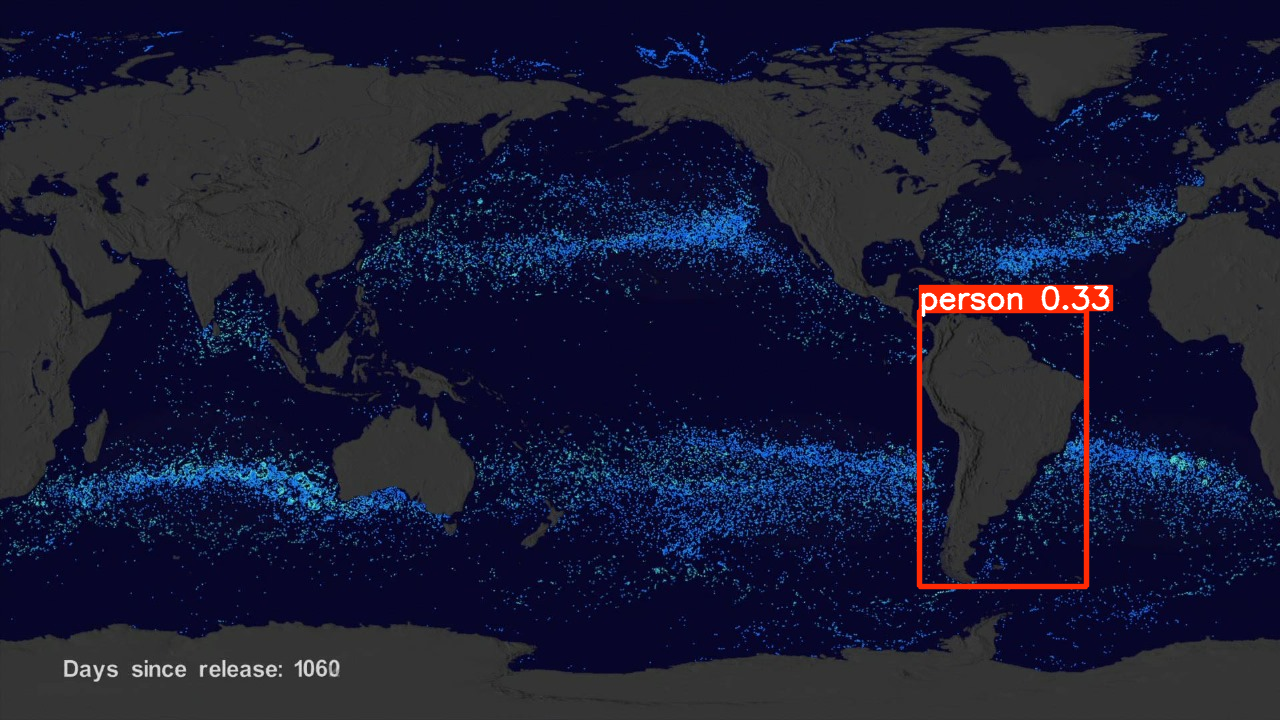

In [5]:
# Quick verification: run the model on a sample repo image and show detections
from PIL import Image
import numpy as np

sample = 'img\satelite-img.jpg'
print('Using sample image:', sample)
img = np.array(Image.open(sample).convert('RGB'))
results = model(img)
r = results[0]
labels = []
for box in getattr(r, 'boxes', []):
    cls = int(box.cls[0])
    name = model.names[cls] if hasattr(model, 'names') else str(cls)
    conf_score = float(box.conf[0])
    labels.append((name, conf_score))

print('Detections found:', len(labels))
for name, conf in labels:
    print('-', name, f'({conf:.3f})')

from IPython.display import display
display(Image.fromarray(r.plot()))


=== img/satelite-img.jpg ===

0: 384x640 2 persons, 136.8ms
Speed: 14.4ms preprocess, 136.8ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)
Result JSON: {'garbage_detections': [], 'all_detections': [{'class': 'person', 'conf': 0.3327, 'bbox': [919.251708984375, 310.0135498046875, 1086.864501953125, 586.72119140625]}, {'class': 'person', 'conf': 0.2409, 'bbox': [861.87890625, 204.2458038330078, 1084.8218994140625, 589.7128295898438]}]}


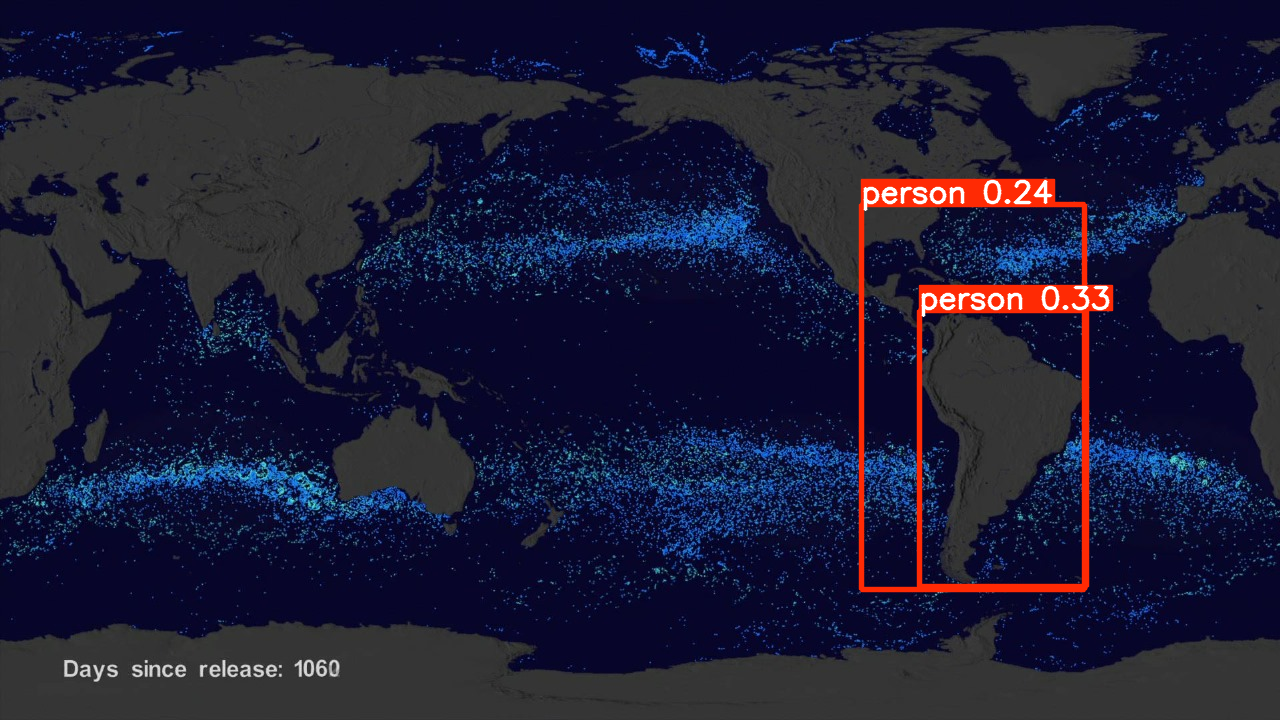


=== img/scuba.jpg ===

0: 448x640 1 person, 1 horse, 119.4ms
Speed: 7.0ms preprocess, 119.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)
Result JSON: {'garbage_detections': [], 'all_detections': [{'class': 'horse', 'conf': 0.5573, 'bbox': [631.5068359375, 133.15257263183594, 1266.0989990234375, 552.428466796875]}, {'class': 'person', 'conf': 0.5046, 'bbox': [633.7806396484375, 135.2200927734375, 1257.29736328125, 549.4464721679688]}]}


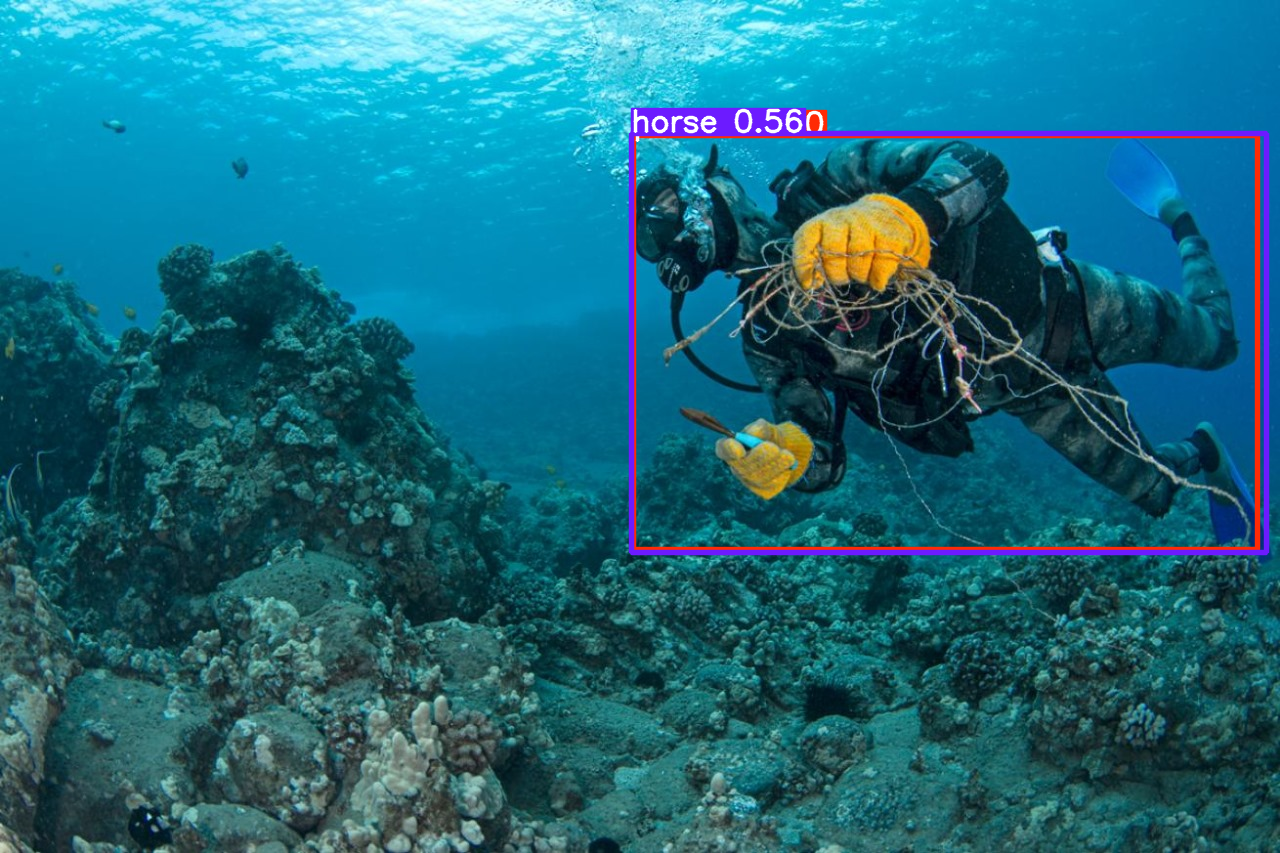


=== img/rov.jpg ===

0: 480x640 1 motorcycle, 117.8ms
Speed: 3.6ms preprocess, 117.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Result JSON: {'garbage_detections': [], 'all_detections': [{'class': 'motorcycle', 'conf': 0.6088, 'bbox': [45.113426208496094, 60.52041244506836, 558.1839599609375, 364.67803955078125]}]}


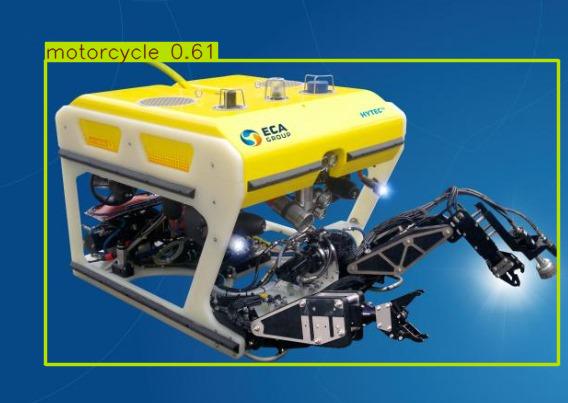


=== img/hardware.jpg ===

0: 512x640 (no detections), 307.6ms
Speed: 4.7ms preprocess, 307.6ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)
Result JSON: {'error': "'ImageDraw' object has no attribute 'textsize'", 'trace': 'Traceback (most recent call last):\n  File "C:\\Users\\Srushti Satte\\AppData\\Local\\Temp\\ipykernel_23912\\1195191489.py", line 79, in detect\n    annotated = _add_no_detections_overlay(np.array(img))\n                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\Srushti Satte\\AppData\\Local\\Temp\\ipykernel_23912\\1324101948.py", line 37, in _add_no_detections_overlay\n    text_w, text_h = draw.textsize(message, font=font)\n                     ^^^^^^^^^^^^^\nAttributeError: \'ImageDraw\' object has no attribute \'textsize\'\n'}
No annotated image returned


In [10]:
# Verification: run `detect()` on a set of sample images and display annotated outputs
from PIL import Image
import numpy as np
from IPython.display import display

samples = ['img/satelite-img.jpg', 'img/scuba.jpg', 'img/rov.jpg', 'img/hardware.jpg']
conf = 0.15

for s in samples:
    print('\n===', s, '===')
    if not os.path.exists(s):
        print('Missing sample:', s)
        continue
    img = np.array(Image.open(s).convert('RGB'))
    annotated, info = detect(img, conf=conf)
    print('Result JSON:', info)
    if annotated is not None:
        display(Image.fromarray(annotated))
    else:
        print('No annotated image returned')